

**Problem Statement:**

Goal: Create a unified hybrid framework that adapts to the commodity type and automatically selects or combines the best models accordingly.

We loaded historical data from 2003-April 2025 alonmg with new realtime data to predict price with pre trained model.

## Step 8 Processing Real Time Data with Pre Trained Models

##### Sourcing Key Libraries


In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [2]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : '../../Data/Historical_Gold_data_April_2015.csv',
           'SILVER': '../../Data/Historical_Silver_data_April.csv',
           'CRUDE_OIL': '../../Data/Historical_Crude_oil_data_April.csv',}

Live_Sentiments_file_name = 'Live_Sentiments.csv'
Live_Sentiments_file_dir = '../../Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = '../../Sentiments'

best_models_dir = {'GOLD': '../../Models/GOLD_MODELS', 'SILVER' : '../../Models/SILVER_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [3]:
commodity = 'GOLD' #input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)

## Data Sourcing

### Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [4]:
# Function to download historical price data
def download_price_data(ticker, start='2015-01-01', end='2025-04-28'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        data = pd.read_csv(filename, header=0)
        
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [5]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : ../../Data/Historical_Gold_data_April_2015.csv
Ticker code for GOLD : GC=F


### Merge Historical Data with Realtime Data

In [6]:
commodity_data


,Date,Open,High,Low,Close,Volume
0,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138
1,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470
2,2015-01-06,1203.500000,1220.000000,1203.500000,1219.300049,97
3,2015-01-07,1219.199951,1219.199951,1210.599976,1210.599976,29
4,2015-01-08,1207.000000,1215.699951,1206.300049,1208.400024,92
...,...,...,...,...,...,...
2587,2025-04-21,3342.199951,3418.500000,3342.199951,3406.199951,78
2588,2025-04-22,3422.199951,3485.600098,3361.699951,3400.800049,785
2589,2025-04-23,3321.199951,3370.300049,3256.199951,3276.300049,331
2590,2025-04-24,3305.399902,3353.899902,3304.899902,3332.000000,560


### Sourcing Market data

####  GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [7]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2025'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [8]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2024-01-01,NaT
1,2024-01-02,NaT
2,2024-01-03,NaT
3,2024-01-04,NaT
4,2024-01-05,NaT
...,...,...
677,2003-01-27,11456450000000.0
678,2003-01-28,11456450000000.0
679,2003-01-29,11456450000000.0
680,2003-01-30,11456450000000.0


####  Interest rate data

In [9]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9528\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25838,2025-03-28,4.33
25839,2025-03-29,4.33
25840,2025-03-30,4.33
25841,2025-03-31,4.33


####  GDP to Debt data

In [10]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
8397,2022-12-28,110.385332
8398,2022-12-29,110.385332
8399,2022-12-30,110.385332
8400,2022-12-31,110.385332


####  Inflation data

In [11]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33


####  ETF data

In [12]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2025-03-28'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'observation_start': '2003-01-01', 'observation_end': '2025-03-28', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'd

## Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [13]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta

# Set up NewsAPI
API_KEY = "250e051931514de6b0e5120412c4e3ad"
NEWS_API_URL = "https://newsapi.org/v2/everything"

# Fetch news using query
def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
        "sortBy": "publishedAt",
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Load FinBERT pipeline
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Combined sentiment fetcher for crude oil-related queries
def get_gold_sentiment():
    queries =  [
    "gold price",
    "gold futures",
    "gold market",
    "gold trading",
    "gold commodity",
    "gold ETF",
    "precious metals",
    "gold demand",
    "gold mining"
]
    all_articles = []

    for query in queries:
        articles = fetch_news(query)
        all_articles.extend(articles)

    if not all_articles:
        return pd.DataFrame()

    df = pd.DataFrame(all_articles, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("gold_sentiment_data.csv", index=False)
    return df


#### Apply Sentiment analysis on Live data and save them in disk

In [14]:
# Save the new data
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)
if os.path.exists(Live_Sentiments_file):
    # sentiment_df = get_gold_sentiment()
    # sentiment_df.to_csv(Live_Sentiments_file, index=False)
    sentiment_df =  pd.read_csv(Live_Sentiments_file)  # File does not exist
else:
    # Fetch sentiment data
    sentiment_df = get_gold_sentiment()
    sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-04-23T17:13:33Z  Costco gold shoppers are cashing in on the com...   
1  2025-04-23T18:01:17Z  Palantir once bought $50 million worth of gold...   
2  2025-04-24T18:00:00Z  Victims Lost $219M to Gold Bar Scams in 2024, ...   
3  2025-04-12T13:22:02Z  Before-and-after photos show changes Trump has...   
4  2025-04-13T12:00:00Z  Scams Tricking Consumers to Invest in Gold Are...   

  Sentiment  
0  positive  
1   neutral  
2   neutral  
3   neutral  
4   neutral  
                   Date                                           Headline  \
0  2025-04-23T17:13:33Z  Costco gold shoppers are cashing in on the com...   
1  2025-04-23T18:01:17Z  Palantir once bought $50 million worth of gold...   
2  2025-04-24T18:00:00Z  Victims Lost $219M to Gold Bar Scams in 2024, ...   
3  2025-04-12T13:22:02Z  Before-and-after photos show changes Trump has...   
4  2025-04-13T12:00:00Z  Scams Tricking Consumers to Inve

,Date,Headline,Sentiment,Sentiment_score
0,2025-04-23,Costco gold shoppers are cashing in on the com...,positive,1
1,2025-04-23,Palantir once bought $50 million worth of gold...,neutral,0
2,2025-04-24,"Victims Lost $219M to Gold Bar Scams in 2024, ...",neutral,0
3,2025-04-12,Before-and-after photos show changes Trump has...,neutral,0
4,2025-04-13,Scams Tricking Consumers to Invest in Gold Are...,neutral,0


#### Load Historical Sentiment data

In [15]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
print(Historical_Sentiments_file)
#Detect Invalid Dates

def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




../../Sentiments\GOLD\Historical_Sentiments.csv
             Date                                           Headline  \
0      2016-01-28  april gold down 20 cents to settle at $1,116.1...   
1      2017-09-13          gold suffers third straight daily decline   
2      2016-07-26     Gold futures edge up after two-session decline   
3      2018-02-28  dent research : is gold's day in the sun comin...   
4      2017-09-06  Gold snaps three-day rally as Trump, lawmakers...   
...           ...                                                ...   
10400  2013-01-07       gold seen falling from 3-week high this week   
10401  2018-09-27  dominic frisby : now looks like a good time to...   
10402  2017-03-03  Gold heading for worst week since November on ...   
10403  2008-06-11  august gold up $7.60 at $878.80 an ounce on nymex   
10404  2007-10-01    december gold down $1 at $749 an ounce on nymex   

      BERT_Sentiment  Sentiment_score  
0           negative               -1  
1      

In [16]:
import pandas as pd
import requests
from transformers import pipeline

# Step 1: Define the events
events = {
    '2003-03-20': 'Iraq War begins, leading to regional instability and oil price increase',
    '2011-01-25': 'Arab Spring uprisings cause oil production disruptions',
    '2022-02-24': 'Russian invasion of Ukraine impacts oil prices due to sanctions and supply disruptions',
    '2008-09-15': 'Aftermath of 2008 Financial Crisis on Oil Prices',
    '2024-01-10': 'U.S. Announces New Sanctions on Russia',
    '2024-02-15': 'Ukraine Military Counteroffensive',
    '2024-03-05': 'Israel-Hamas Conflict Escalation',
    '2024-04-12': 'Iran Nuclear Talks Stalled'
}

# Step 2: Create a DataFrame for the events
event_df = pd.DataFrame(list(events.items()), columns=['Date', 'Title'])

# Step 3: Load the sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Step 4: Perform sentiment analysis on the event titles
event_sentiments = sentiment_pipeline(event_df['Title'].tolist())

# Step 5: Convert sentiment analysis results to DataFrame
sentiment_df = pd.DataFrame(event_sentiments)

# Step 6: Map sentiment labels to numerical values
event_df['Sentiment'] = sentiment_df['label'].apply(lambda x: 1 if x == 'POSITIVE' else -1 if x == 'NEGATIVE' else 0)
# Step 8: Convert 'Date' to datetime for merging

event_df['Date'] = pd.to_datetime(event_df['Date'], errors='coerce')
event_df['Date'] = event_df['Date'].dt.tz_localize(None).dt.date 
#gold_data['Date'] = pd.to_datetime(gold_data['Date']).dt.tz_localize(None).dt.date 
event_df.head()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


,Date,Title,Sentiment
0,2003-03-20,"Iraq War begins, leading to regional instabili...",-1
1,2011-01-25,Arab Spring uprisings cause oil production dis...,-1
2,2022-02-24,Russian invasion of Ukraine impacts oil prices...,-1
3,2008-09-15,Aftermath of 2008 Financial Crisis on Oil Prices,-1
4,2024-01-10,U.S. Announces New Sanctions on Russia,-1


## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [17]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [18]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [19]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [20]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2592 non-null   object 
 1   Open            2592 non-null   float64
 2   High            2592 non-null   float64
 3   Low             2592 non-null   float64
 4   Close           2592 non-null   float64
 5   Volume          2592 non-null   int64  
 6   GDP             180 non-null    object 
 7   Interest_rates  81 non-null     float64
 8   Inflation_rate  81 non-null     float64
 9   DebtToGDP       2011 non-null   float64
 10  ETF_Value       51 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 222.9+ KB
Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
GDP               2412
Interest_rates    2511
Inflation_rate    2511
DebtToGDP          581
ETF_Value     

### 2.4 Processing NULL values from merged data

In [21]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

#  Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation
    merged_data[col].fillna(0, inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9528\3625551758.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9528\3625551758.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Te

### Outlier Treatment

In [22]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
2535,2025-02-04,2827.600098,2853.300049,2816.100098,2853.300049,2187,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2536,2025-02-05,2850.000000,2880.500000,2848.000000,2871.600098,4519,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2537,2025-02-06,2865.199951,2871.699951,2836.300049,2856.000000,3116,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2538,2025-02-07,2859.899902,2889.500000,2857.800049,2867.300049,1822,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2539,2025-02-10,2864.199951,2916.100098,2863.800049,2914.300049,2237,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2540,2025-02-11,2925.500000,2945.399902,2890.000000,2912.500000,2554,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2541,2025-02-12,2902.000000,2912.300049,2868.600098,2909.000000,2504,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2542,2025-02-13,2911.300049,2937.699951,2910.600098,2925.899902,4670,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2543,2025-02-14,2937.300049,2944.399902,2874.800049,2883.600098,1992,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2544,2025-02-18,2879.199951,2936.399902,2873.800049,2931.600098,4010,2.196576e+13,1.815679,1.815679,105.461049,1.377451


In [23]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138,1.829502e+13,1.815679,1.815679,95.956145,1.377451
1,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,1.377451
2,2015-01-06,1203.500000,1220.000000,1203.500000,1219.300049,97,1.829502e+13,1.815679,1.815679,95.956145,1.377451
3,2015-01-07,1219.199951,1219.199951,1210.599976,1210.599976,29,1.829502e+13,1.815679,1.815679,95.956145,1.377451
4,2015-01-08,1207.000000,1215.699951,1206.300049,1208.400024,92,1.829502e+13,1.815679,1.815679,95.956145,1.377451
...,...,...,...,...,...,...,...,...,...,...,...
2587,2025-04-21,3342.199951,3418.500000,3342.199951,3406.199951,78,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2588,2025-04-22,3422.199951,3485.600098,3361.699951,3400.800049,785,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2589,2025-04-23,3321.199951,3370.300049,3256.199951,3276.300049,331,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2590,2025-04-24,3305.399902,3353.899902,3304.899902,3332.000000,560,2.196576e+13,1.815679,1.815679,105.461049,1.377451


###  Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [24]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [25]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


           Date  Sentiment_score
4335 2000-02-15                0
9681 2000-02-17               -1
1972 2000-03-24               -1
2281 2000-04-27                1
8701 2000-05-04               -1


In [26]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [27]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
2587,2025-04-21,3342.199951,3418.500000,3342.199951,3406.199951,78,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2588,2025-04-22,3422.199951,3485.600098,3361.699951,3400.800049,785,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2589,2025-04-23,3321.199951,3370.300049,3256.199951,3276.300049,331,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2590,2025-04-24,3305.399902,3353.899902,3304.899902,3332.000000,560,2.196576e+13,1.815679,1.815679,105.461049,1.377451
2591,2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451


### 2.8 Merging Sentiment Data with Gold Data

In [28]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138,1.829502e+13,1.815679,1.815679,95.956145,1.377451,-1.0
1,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138,1.829502e+13,1.815679,1.815679,95.956145,1.377451,-1.0
2,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,1.377451,1.0
3,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,1.377451,-1.0
4,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,1.377451,1.0


In [29]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
-1.0    2214
 1.0    1874
 0.0     793
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [30]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9528\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [31]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
-1    2726
 1    2630
 0    1143
Name: count, dtype: int64

In [32]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138,1.829502e+13,1.815679,1.815679,95.956145,1.377451,1
1,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0
2,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0
3,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0
4,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6494,2025-04-24,3305.399902,3353.899902,3304.899902,3332.000000,560,2.196576e+13,1.815679,1.815679,105.461049,1.377451,1
6495,2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451,-1
6496,2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451,1
6497,2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451,-1


## Step 3 : Feature Engineering

### 4.1 Create Features 

In [33]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    df['tomorrow_price'] = df['Close'].shift(-1)
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()

    return df


### 4.2 Apply Feature engineering on data

In [34]:
commodity_data = feature_engineering(commodity_data)

In [35]:
feature_engineering(commodity_data)

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
0,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,1186.000000,NaN,NaN,NaN,1.000000,1.000000
1,2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,138,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,1203.900024,0.000000,NaN,NaN,0.500000,0.500000
2,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,1203.900024,0.014980,NaN,NaN,0.333333,0.333333
3,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,1203.900024,0.000000,NaN,NaN,0.250000,0.250000
4,2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,470,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,1219.300049,0.000000,NaN,NaN,0.200000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6494,2025-04-24,3305.399902,3353.899902,3304.899902,3332.000000,560,2.196576e+13,1.815679,1.815679,105.461049,...,3204.800049,3316.085728,3330.063346,3141.644444,3282.399902,0.000000,27.178793,56.292251,-0.142857,-0.333333
6495,2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,...,3218.699951,3316.957136,3332.186678,3146.079999,3282.399902,-0.014998,25.750857,53.055095,-0.214286,-0.333333
6496,2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,...,3218.699951,3317.828544,3334.310010,3151.031109,3282.399902,0.000000,24.202369,49.513035,-0.214286,-0.266667
6497,2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,...,3326.600098,3310.742815,3332.836670,3155.388886,3282.399902,0.000000,26.512367,50.400046,-0.357143,-0.266667


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
Low,0.999799
High,0.999722
lag_1,0.999610
tomorrow_price,0.999610
Open,0.999513
MA_7,0.999302
lag_7,0.997402
MA_30,0.996991
MA_90,0.992029


### 4.3 Seting Index of data frame is as a Date column

In [37]:
commodity_data_df = commodity_data
commodity_data_df.set_index('Date', drop=True, inplace=True)

In [38]:
commodity_data_df.tail()

,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-24,3305.399902,3353.899902,3304.899902,3332.000000,560,2.196576e+13,1.815679,1.815679,105.461049,1.377451,...,3204.800049,3316.085728,3330.063346,3141.644444,3282.399902,0.000000,27.178793,56.292251,-0.142857,-0.333333
2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451,...,3218.699951,3316.957136,3332.186678,3146.079999,3282.399902,-0.014998,25.750857,53.055095,-0.214286,-0.333333
2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451,...,3218.699951,3317.828544,3334.310010,3151.031109,3282.399902,0.000000,24.202369,49.513035,-0.214286,-0.266667
2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451,...,3326.600098,3310.742815,3332.836670,3155.388886,3282.399902,0.000000,26.512367,50.400046,-0.357143,-0.266667
2025-04-25,3355.500000,3355.500000,3266.100098,3282.399902,162,2.196576e+13,1.815679,1.815679,105.461049,1.377451,...,3326.600098,3303.657087,3331.363330,3159.531106,NaN,0.000000,26.512367,51.227897,-0.285714,-0.233333


### Step 5 Data Split and Scaling

In [39]:
import pandas as pd

# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.95) 
# split_date =  pd.to_datetime('2022-01-01')
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (6175, 23), Test size: (325, 23)


In [40]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=['tomorrow_price', 'Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=['tomorrow_price', 'Close'])
y_test = test_df['Close']
 

In [41]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)


# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()




### 8.1 Load pre trained model from File

In [42]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        model = model.fit(X_train_scaled_minmax, y_train_scaled)
        xgb_predictions = model.predict(X_test_scaled_minmax)
        xgb_prediction = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        y_test_org = scaler_minmax.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
        return scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()

    elif "RF" in model_name.upper():
        random_search = model.fit(X_train_scaled_minmax, y_train_scaled)
        y_pred_rf = random_search.predict(X_test_scaled_minmax)
        return  scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

    elif "LSTM" in model_name.upper():
        #  Select Sentiment + Microeconomic Features
        selected_features = [
            'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
            'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
            'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
        ]
        
        # Extract Features for Training & Testing
        X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
        X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values
        
        #  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
        look_back = 14  # Using the same look-back period
        
        def create_sequences(X, y, look_back):
            Xs, ys = [], []
            for i in range(len(X) - look_back):
                Xs.append(X[i:i + look_back])
                ys.append(y[i + look_back])
            return np.array(Xs), np.array(ys)
        
        X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
        X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)
        #  Train Model
        model = model.fit(
            X_train_seq, y_train_seq,
            epochs=50, batch_size=32, 
            validation_data=(X_test_seq, y_test_seq),
            verbose=1
        )
        
        #  Predict on Test Set
        y_pred_lstm_scaled = model.predict(X_test_seq)
        
        #  Inverse Transform Predictions to Original Scale
        y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)
        return y_pred_lstm_original

    elif "ARIMA" in model_name.upper(): 
        # Select microeconomic factors from the scaled data
        # Select microeconomic factors from the scaled data
        exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in X_train.columns]]
        exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in X_test.columns]]
        model2 = model.get_forecast(steps=len(y_test), exog=exog_test)
        fc_model2 = model2.predicted_mean
        return fc_model2.values
        
    elif "GARCH" in model_name.upper():
        y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
        y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()
        garch_forecast = model.forecast(horizon=len(y_test_log_returns))
        garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()
        # Convert forecasted log returns back to price predictions
        y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
        garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))
        return garch_predicted_prices
        
    elif "VAR" in model_name.upper():
        # Ensure data is stationary (apply differencing)
        train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                              'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                            'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        
        # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
        test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
        
        # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
        # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
        
        # Select optimal lag using BIC
        var_model = VAR(endog=train_var, exog=train_exog)
        lag_selection = var_model.select_order(maxlags=15)
        optimal_lag = lag_selection.bic
        print(f"Optimal lag order (BIC): {optimal_lag}")
        
        # Fit VAR model
        var_fitted = var_model.fit(optimal_lag)
        
        # Forecast
        forecast_steps = len(test_var)
        last_observations = train_var.values[-optimal_lag:]
        
        # Forecast with exogenous variables
        var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
        
        # Convert forecasted differenced values back to original scale
        forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
        forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
        
        # Extract predicted Close prices
        predicted_prices = forecast_df_m4['Close']
        return predicted_prices
    else:
        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_d= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_d[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: ARIMA_best-1
Predicted values: [2382.15867205 2399.87028795 2413.76400365 2429.83040068 2451.70280983
 2450.57827239 2472.26763846 2479.20112626 2487.08658105 2479.57339493
 2493.59537549 2496.20697938 2501.48643632 2517.518491   2508.41993413
 2513.23931003 2523.66696397 2485.41776101 2477.30034286 2475.58568351
 2478.16574567 2482.16423875 2488.60344607 2456.25097938 2458.39012864
 2458.27259102 2457.64466549 2471.9672708  2469.47645511 2468.00520453
 2478.95190911 2501.94332463 2485.38042337 2493.33451338 2515.40852616
 2513.63669734 2531.67746922 2547.34712468 2542.55769195 2522.12651803
 2487.0237273  2481.6681276  2494.94520933 2487.40354816 2487.23788211
 2475.4409608  2487.67895815 2477.09814962 2492.89849239 2504.88261356
 2466.37622664 2463.67302244 2463.92671418 2480.97952242 2461.31068724
 2477.78607509 2468.30610788 2477.99121268 2493.34641079 2472.65343369
 2478.41200346 2471.25762242 2459.73698942 2473.86802455 2477.65081988
 2477.79927181 2474.8

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### 8.2 Load Pretrained Hybrid Model

In [43]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Get individual model forecasts
best1_forecast_trimmed, best2_forecast_trimmed = list(predict_d.values())

# Ensure both forecasts are the same length
min_length = min(len(best1_forecast_trimmed), len(best2_forecast_trimmed))

best1_forecast_trimmed = best1_forecast_trimmed[:min_length]
best2_forecast_trimmed = best2_forecast_trimmed[:min_length]

# Now combine
X_combined = np.column_stack((best1_forecast_trimmed, best2_forecast_trimmed))

# Normalize features
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Predict using stacked model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


### 8.3 Predict Price with Stacked Hybrid Model

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 1 # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-04-26       3371.58543


### 8.4 Let's verify Price with Weighted Hybrid Model

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
min_length = min(len(best1_forecast_trimmed),len(best2_forecast_trimmed))
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)



### 8.5 Predict Price with Weighted Hybrid Model

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Weighted': hybrid_weighted_future,
}, index=future_dates)
print(future_price)

            Hybrid_Weighted
2025-04-26        3269.1741


### 8.6 Future Price Prediction and recommendation to Buy or Sell

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n = 1  # Number of future predictions
threshold = 100  # Decision threshold in USD

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Scale and Predict
scaler_minmax.fit(X_combined)  # Use previously prepared training combined features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Hybrid predictions
hybrid_predictions_stacked = meta_model.predict(X_combined_future_scaled).flatten()
hybrid_predictions_weighted = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
hybrid_predictions_average = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# Step 4: Store Future Predictions
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_weighted': hybrid_predictions_weighted,
    'Future Price_stacked': hybrid_predictions_stacked,

}, index=future_dates)

# Step 5: Last Observed Price
last_actual_price = y_test.values[-1]

# Step 6: Recommendation Based on Stacked Hybrid
recommendation = []
for forecast in hybrid_predictions_weighted:
    price_diff = forecast - last_actual_price
    if price_diff > threshold:
        recommendation.append("BUY 📈")
    elif price_diff < -threshold:
        recommendation.append("SELL 📉")
    else:
        recommendation.append("HOLD ⚖️")

future_price['Recommendation'] = recommendation

# Display Predictions
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted future values and investment recommendation:")
print(future_price)

# ======================================
# Evaluation Metrics on Known y_test[-n:]
# ======================================
actual_values = y_test[-n:].values.flatten()

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Store results
metrics_summary = {
    "Model": [  "Average Hybrid","Stacked Hybrid"],

    "MAPE": [
        mape(actual_values, hybrid_predictions_weighted),
        mape(actual_values, hybrid_predictions_stacked),

    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_weighted)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_stacked)),

    ],
    "MAE": [
        mean_absolute_error(actual_values, hybrid_predictions_weighted),
        mean_absolute_error(actual_values, hybrid_predictions_stacked),

    ],
}

# Convert to DataFrame and show
metrics_df = pd.DataFrame(metrics_summary)
print("\n Evaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))


Last Actual Observed Price: 3282.40

Predicted future values and investment recommendation:
            Future Price_weighted  Future Price_stacked Recommendation
2025-04-26              3269.1741            3371.58543        HOLD ⚖️

 Evaluation Metrics (on last known actual prices):
            Model    MAPE     RMSE      MAE
0  Average Hybrid  0.4029  13.2258  13.2258
1  Stacked Hybrid  2.7171  89.1855  89.1855


In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n = 5  # Number of future predictions
threshold = 100  # Decision threshold in USD

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Scale and Predict
scaler_minmax.fit(X_combined)  # Use previously prepared training combined features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Hybrid predictions
hybrid_predictions_weighted = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
hybrid_predictions_stacked = meta_model.predict(X_combined_future_scaled).flatten()
hybrid_predictions_average = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# Step 4: Store Future Predictions
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price Weighted': hybrid_predictions_weighted,
    'Future Price Stacked': hybrid_predictions_stacked,
    'Future Price Average': hybrid_predictions_average
}, index=future_dates)

# Step 5: Last Observed Price
last_actual_price = y_test.values[-1]

# Step 6: Recommendation Based on Weighted Hybrid
recommendation = []
for forecast in hybrid_predictions_weighted:
    price_diff = forecast - last_actual_price
    if price_diff > threshold:
        recommendation.append("BUY 📈")
    elif price_diff < -threshold:
        recommendation.append("SELL 📉")
    else:
        recommendation.append("HOLD ⚖️")

future_price['Recommendation'] = recommendation

# Display Predictions
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted future values and investment recommendation:")
print(future_price)

# ======================================
# Evaluation Metrics on Known y_test[-n:]
# ======================================
actual_values = y_test[-n:].values.flatten()

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y_true, y_pred):
    return 100 - mape(y_true, y_pred)

# Store results
metrics_summary = {
    "Model": ["Average Hybrid", "Weighted Hybrid", "Stacked Hybrid"],
    
    "MAPE": [
        mape(actual_values, hybrid_predictions_average),
        mape(actual_values, hybrid_predictions_weighted),
        mape(actual_values, hybrid_predictions_stacked)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_average)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_weighted)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_stacked))
    ],
    "MAE": [
        mean_absolute_error(actual_values, hybrid_predictions_average),
        mean_absolute_error(actual_values, hybrid_predictions_weighted),
        mean_absolute_error(actual_values, hybrid_predictions_stacked)
    ],
    "Accuracy (%)": [
        accuracy(actual_values, hybrid_predictions_average),
        accuracy(actual_values, hybrid_predictions_weighted),
        accuracy(actual_values, hybrid_predictions_stacked)
    ]
}

# Convert to DataFrame and show
metrics_df = pd.DataFrame(metrics_summary)
print("\nEvaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))


Last Actual Observed Price: 3282.40

Predicted future values and investment recommendation:
            Future Price Weighted  Future Price Stacked  Future Price Average  \
2025-04-26            3275.218704           3368.845147           3248.598939   
2025-04-27            3289.136291           3385.824583           3253.605824   
2025-04-28            3263.478962           3366.565082           3231.424907   
2025-04-29            3270.182489           3372.440056           3236.313469   
2025-04-30            3269.174100           3371.585430           3235.546849   

           Recommendation  
2025-04-26        HOLD ⚖️  
2025-04-27        HOLD ⚖️  
2025-04-28        HOLD ⚖️  
2025-04-29        HOLD ⚖️  
2025-04-30        HOLD ⚖️  

Evaluation Metrics (on last known actual prices):
             Model    MAPE     RMSE      MAE  Accuracy (%)
0   Average Hybrid  1.5529  54.2263  51.2219       98.4471
1  Weighted Hybrid  0.6522  28.1129  21.5764       99.3478
2   Stacked Hybrid  2.456

In [53]:
metrics_df.round(4)

,Model,MAPE,RMSE,MAE,Accuracy (%)
0,Average Hybrid,1.5529,54.2263,51.2219,98.4471
1,Weighted Hybrid,0.6522,28.1129,21.5764,99.3478
2,Stacked Hybrid,2.4562,83.9039,80.7321,97.5438


In [54]:
print("\n Evaluation Metrics (on last known actual prices) with historical data from 2003:")
metrics_df


 Evaluation Metrics (on last known actual prices) with historical data from 2003:


,Model,MAPE,RMSE,MAE,Accuracy (%)
0,Average Hybrid,1.552938,54.226293,51.221924,98.447062
1,Weighted Hybrid,0.652185,28.112928,21.576368,99.347815
2,Stacked Hybrid,2.456204,83.903867,80.732138,97.543796


## Conclusion

Last Actual Observed Price: 3282.40

 Predicted Future Prices and Strategy:

            Future Price_weighted  Future Price_stacked Recommendation Signal
2025-04-26            3263.478962           3366.565082        HOLD ⚖️       
2025-04-27            3270.182489           3372.440056        HOLD ⚖️       
2025-04-28            3269.174100           3371.585430        HOLD ⚖️       


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9528\3326160823.py:76: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


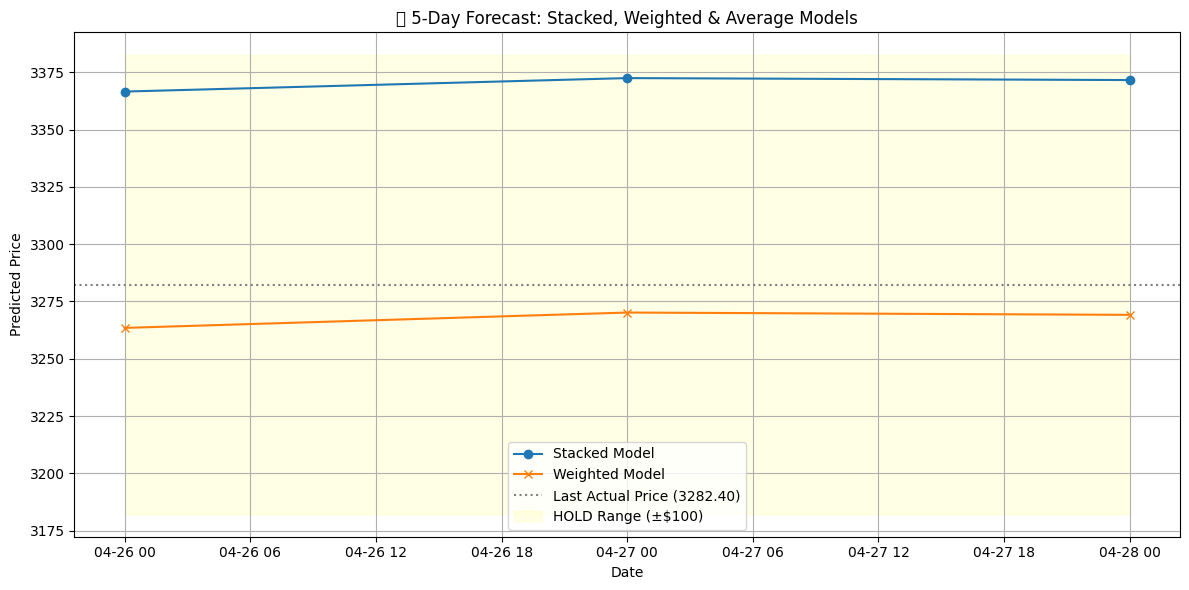

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
n = 3  # Number of future predictions (default: 5 days)2
threshold = 100  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_weighted': hybrid_weighted_future,
    'Future Price_stacked': hybrid_predictions_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_weighted_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY 📈")
    elif diff < -threshold:
        recommendations.append("SELL 📉")
    else:
        recommendations.append("HOLD ⚖️")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend

# === Display Summary ===
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print(" Predicted Future Prices and Strategy:\n")
print(future_price)

# === Plot Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price_stacked'], label='Stacked Model', marker='o')
plt.plot(future_price.index, future_price['Future Price_weighted'], label='Weighted Model', marker='x')
plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$100)')
plt.title("📈 5-Day Forecast: Stacked, Weighted & Average Models")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
